# RBM Wavefunction with NetKet for the 1D Transverse Field Ising Model

In this notebook, we will explore how to use the NetKet library to implement a Restricted Boltzmann Machine (RBM) wavefunction. We will specifically focus on using this RBM wavefunction to find the ground state of the 1D Transverse Field Ising Model.

The Transverse Field Ising Model is a well-known model in statistical physics that describes a chain of spins interacting with each other and subjected to a transverse magnetic field. The ground state of this model represents the lowest energy configuration of the spins.

NetKet is a powerful library for performing quantum many-body calculations using neural networks. It provides a flexible framework for implementing RBM wavefunctions and optimizing them to find the ground state of various quantum systems.

In this notebook, we will walk through the steps of setting up the RBM wavefunction using NetKet, defining the Hamiltonian for the 1D Transverse Field Ising Model, and using variational Monte Carlo methods to find the ground state energy and wavefunction.

Let's get started!

### Import libraries

Import `numpy` as well as `netket` for this notebook. We will be setting the environment variable `JAX_PLATFORM_NAME` to use the CPU, as there is not much difference in using the GPU for systems smaller than 40 spins.

In [1]:
import jax
import jax.numpy as jnp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

import netket as nk
from netket.operator.spin import sigmaz, sigmax
from netket.models import RBMSymm

import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

/home/marcfernandez/.pyenv/versions/3.9.6/envs/myenv-3.9.6/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Translation Symmetry

One advantage of using NetKet is that we can enforce spatial symmetries in our model using some built-in functionalities of the library.

In the TFI model, specifically, we have a simple chain with periodic boundaries, leading to a translational symmetry that we can exploit to simplify the structure of our RBM wavefunction.

For starters, let us construct a graph that contains the edges of our interactions.

In [2]:
# Number of spins, length of the chain
N = 20

graph = nk.graph.Chain(length=N, pbc=True)
print(graph.translation_group())

PermutationGroup(elems=[Id(), Translation([1]), Translation([2]), Translation([3]), Translation([4]), Translation([5]), Translation([6]), Translation([7]), Translation([8]), Translation([9]), Translation([10]), Translation([11]), Translation([12]), Translation([13]), Translation([14]), Translation([15]), Translation([16]), Translation([17]), Translation([18]), Translation([19])], degree=20)


With this graph, we can define the problem Hamiltonian very simply as

In [3]:
# Initialize Hilber spin space
hi = nk.hilbert.Spin(s = 1/2, N = N)

# Define the coupling interaction term
J = 2.0
H = -sum([J * sigmaz(hi, i) * sigmaz(hi, j) for i,j in graph.edges()])

# Define the transverse field term
B = 1.0
H -= sum([B * sigmax(hi, i) for i in range(N)])

We now make use of NetKet's own `nn` module to call `RBMSymm`, a symmetrized RBM that we will use to account for the invariant transformation given by the translation group.

We will also consider complex parametrization, as stated in the report.

In [4]:
# Define the sampler
sampler = nk.sampler.MetropolisLocal(hi)

# Define the model with 4 features per symmetry
model = RBMSymm(
    alpha=4, 
    param_dtype=jnp.complex64,
    symmetries=graph.translation_group()
    )

# Define the variational state
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

# Number of parameters
n_params = vstate.n_parameters
print(f"Number of parameters: {n_params}")

Number of parameters: 85


/home/marcfernandez/.pyenv/versions/3.9.6/envs/myenv-3.9.6/lib/python3.9/site-packages/netket/vqs/mc/mc_state/state.py:248: UserWarning: n_samples=1000 (1000 per device/MPI rank) does not divide n_chains=16, increased to 1008 (1008 per device/MPI rank)
  self.n_samples = n_samples


As we can see, the number of parameters in this model is greatly reduced due to the symmetries imposing constraints on the weights of the RBM layers.

Recall that for $N = 20$, and feature density $N_h = 4N$, we had $N + N_h + N\cdot N_h = 1700$ different parameters.

With this, we can now optimize the model using more optimization steps compared to the normal RBM model.

In [5]:
# Define optimizer
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Define the ground-state optimization driver
gs = nk.driver.VMC(
    hamiltonian=H,
    optimizer=optimizer, 
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(
        diag_shift=0.1,
        holomorphic=True
        )
    )

# Logging and running the optimization
log = nk.logging.RuntimeLog()
gs.run(n_iter=600, out=log)

# Compute the exact ground state energy
sp_h = H.to_sparse()

eig_vals, eig_vecs = eigsh(sp_h, k=1, which="SA")

# Calculate the expectation value of the Hamiltonian for
# the optimized variational state
symm_energy = vstate.expect(H)

# Print relative error
error = abs((symm_energy.mean - eig_vals) / eig_vals)
print(f"Optimized energy and relative error: {symm_energy}, {error}")


100%|██████████| 600/600 [01:42<00:00,  5.85it/s, Energy=-42.5405+0.0005j ± 0.0017 [σ²=0.0029, R̂=1.0089]]    


Optimized energy and relative error: -42.5418-0.0005j ± 0.0011 [σ²=0.0012, R̂=1.0187], [1.08099468e-05]


The optimized energy is quite good compared to the one we obtained with the general RBM implementation, we can also plot the model energy over the iterations:

/home/marcfernandez/.pyenv/versions/3.9.6/envs/myenv-3.9.6/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/marcfernandez/.pyenv/versions/3.9.6/envs/myenv-3.9.6/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/marcfernandez/.pyenv/versions/3.9.6/envs/myenv-3.9.6/lib/python3.9/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


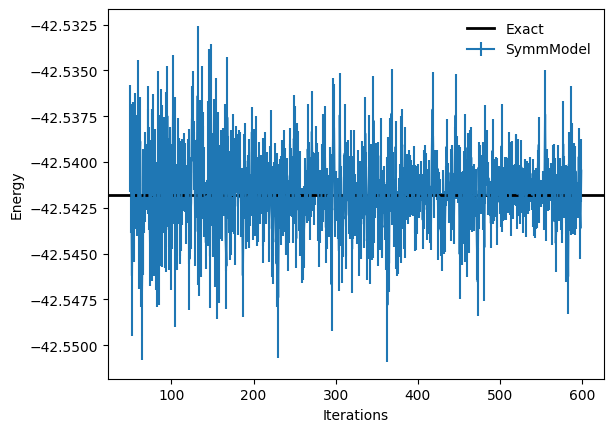

In [6]:
plt.errorbar(log.data["Energy"].iters[50:],log.data["Energy"].Mean[50:],yerr=log.data["Energy"].Sigma[50:],label="SymmModel")

plt.axhline(y=eig_vals, xmin=0, xmax=log.data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

### Measuring correlations

Once we optimize the model, we can of course calculate other observables, such as the correlation between nearest neighbors (which is related to the magnetization):

In [7]:
corr = sum([sigmax(hi, i) * sigmax(hi, j) for (i,j) in graph.edges()])

vstate.n_samples = 40000

vstate.expect(corr)

1.960+0.000j ± 0.031 [σ²=22.690, R̂=1.0004]

Compared to the exact result:

In [8]:
psi = eig_vecs[:, 0]
exact_corr = psi.conj() @ corr.to_sparse() @ psi
print(exact_corr)

NameError: name 'eig_vecs' is not defined